<a href="https://colab.research.google.com/github/95ImadEL/Tensorflow-basics/blob/main/Lego_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import zipfile

# Download data
#!wget https://github.com/95ImadEL/Tensorflow-basics/raw/main/Lego.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("Lego.zip", "r")
zip_ref.extractall()
zip_ref.close()



In [210]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 2

train_dir = "Lego/train/"
test_dir = "Lego/test/"

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )
test_datagen = ImageDataGenerator(rescale=1/255.,
                                  )

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                classes={'technic': 1, 
                                                        'standard': 0},
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             classes={'technic': 1, 
                                             'standard': 0},
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 20 images belonging to 2 classes.
Testing images:
Found 10 images belonging to 2 classes.


In [218]:
train_data.class_indices['technic']=1
train_data.class_indices['standard']=0

print(train_data.class_indices)

{'technic': 1, 'standard': 0}


Text(0.5, 1.0, '0.0')

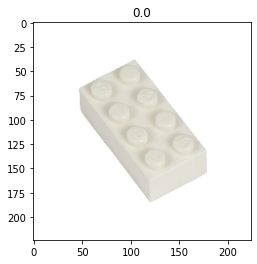

In [225]:
img, labels= test_data.next()
plt.imshow(img[0])
plt.title(labels[0][0])

In [135]:
print(train_data.num_classes)

2


In [226]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

inception_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

# Downloading the pretrained model and saving it as a Keras layer 
inception_feature_extraction_layer = hub.KerasLayer(inception_url ,
                                                    trainable = False , 
                                                    input_shape = IMAGE_SHAPE + (3,))

# Building a Sequential model with our mobilenet feature extraction layer 
inception_model = tf.keras.Sequential([
  inception_feature_extraction_layer, 
  layers.Dense(train_data.num_classes , activation= 'softmax' , name ='output_layer')                             
])

# Printing the summarr of the model 
inception_model.summary() 

# Compile
inception_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(lr=0.001),
                     metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 output_layer (Dense)        (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [256]:
# Fit the model
inception_history = inception_model.fit(train_data,
                                  epochs=10,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                 ) 

Epoch 1/10
10/10 [==============================] - 4s 380ms/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 0.1489 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 4s 371ms/step - loss: 0.0632 - accuracy: 1.0000 - val_loss: 0.1477 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 4s 373ms/step - loss: 0.0983 - accuracy: 0.9500 - val_loss: 0.1448 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 4s 361ms/step - loss: 0.0542 - accuracy: 1.0000 - val_loss: 0.1414 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 4s 366ms/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 0.1381 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 4s 365ms/step - loss: 0.0378 - accuracy: 1.0000 - val_loss: 0.1345 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 4s 372ms/step - loss: 0.0473 - accuracy: 1.0000 - val_loss: 0.1366 - val_accuracy: 1.0000
Epoch 

In [257]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

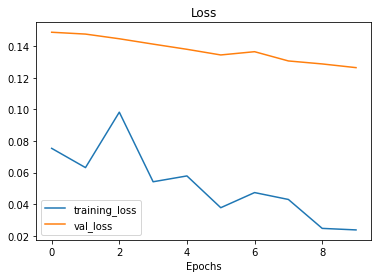

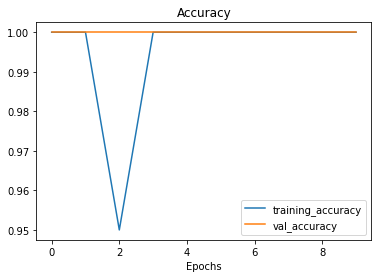

In [258]:
plot_loss_curves(inception_history)

In [259]:
inception_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 output_layer (Dense)        (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [260]:
inception_model.evaluate(test_data)

5/5 [==============================] - 1s 230ms/step - loss: 0.1265 - accuracy: 1.0000


[0.1264895647764206, 1.0]

In [271]:
import pathlib
import numpy as np

data_dir = pathlib.Path("Lego/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['standard' 'technic']


In [262]:
# Create a function to import an image and resize it to be able to be used with our model

def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels) 
  img = tf.image.decode_image(img, channels=3)
  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img,size=[img_shape,img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img
     

In [263]:
def pred_and_plot(model, filename, class_names):

  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
     

1/1 [==============================] - 0s 121ms/step


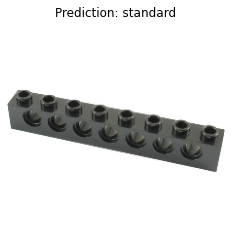

In [278]:
pred_and_plot(inception_model, "1.jpg", class_names)

1/1 [==============================] - 0s 135ms/step


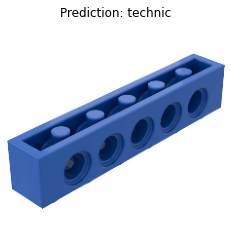

In [279]:
pred_and_plot(inception_model, "2.jpg", class_names)

1/1 [==============================] - 0s 123ms/step


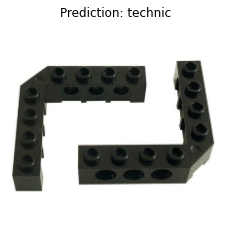

In [280]:
pred_and_plot(inception_model, "3.jpg", class_names)

1/1 [==============================] - 0s 126ms/step


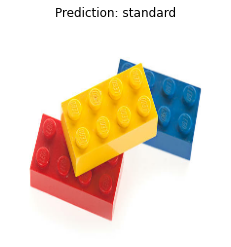

In [283]:
pred_and_plot(inception_model, "4.jpg", class_names)

1/1 [==============================] - 0s 125ms/step


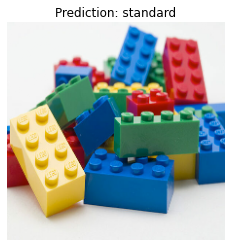

In [284]:
pred_and_plot(inception_model, "6.jpg", class_names)

1/1 [==============================] - 0s 122ms/step


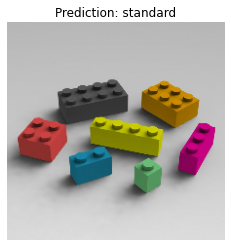

In [281]:
pred_and_plot(inception_model, "7.jpg", class_names)

1/1 [==============================] - 0s 120ms/step


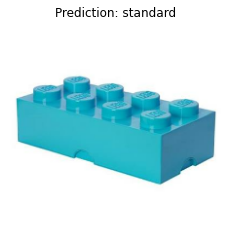

In [282]:
pred_and_plot(inception_model, "8.jpg", class_names)